In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


[INFO] Cargando REAL (estratificado por label)...


Sampling MachineLearningCVE_full_clean.csv: 0chunk [00:00, ?chunk/s]

[OK] REAL sample: (400000, 80) | label: {0: 200000, 1: 200000}

[INFO] Cargando SYN (estratificado por label)...


Sampling synthetic_MachineLearningCVE_ctgan.csv: 0chunk [00:00, ?chunk/s]

[OK] SYN sample: (235000, 80) | label: {0: 145000, 1: 90000}

[INFO] Split REAL:
  train: (320000, 79) test: (80000, 79)

[INFO] Fit preprocesador (OHE sparse) sobre REAL_train + SYN...
[OK] common_cols=79 | cat=1 | num=78

==================== XGB R→R (train REAL) ====================
Accuracy: 1.0000 | F1(w): 1.0000 | F1(macro): 1.0000

[Classification report]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     40000
           1     1.0000    1.0000    1.0000     40000

    accuracy                         1.0000     80000
   macro avg     1.0000    1.0000    1.0000     80000
weighted avg     1.0000    1.0000    1.0000     80000


[Confusion matrix] (filas=real, cols=pred)
[[40000     0]
 [    0 40000]]

==================== XGB S→R (train SYN) ====================
Accuracy: 1.0000 | F1(w): 1.0000 | F1(macro): 1.0000

[Classification report]
              precision    recall  f1-score   support

           0     1.0000    1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[INFO] n_features SHAP: 82


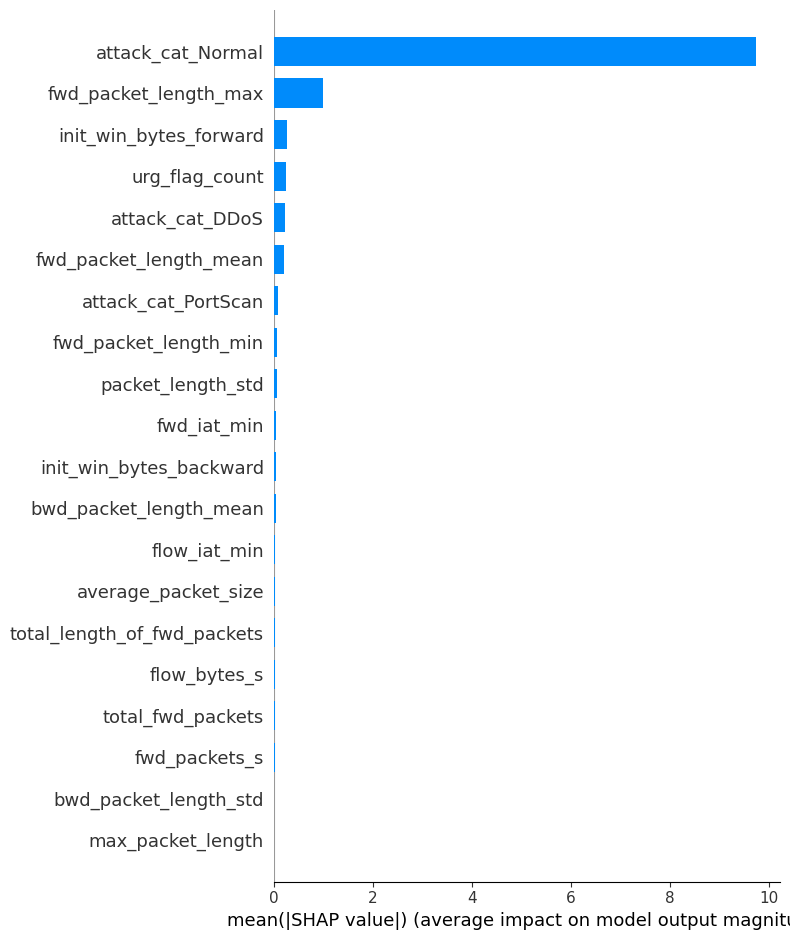


[FIN] CICIDS binario + R→R / S→R / M→R + SHAP listo.


In [ ]:
# ===================== CICIDS (MachineLearningCVE) — BINARIO (label) + XGB + SHAP (pericial) =====================
# Escenarios:
#  - R→R: train REAL, test REAL
#  - S→R: train SYN,  test REAL
#  - M→R: train (REAL + parte SYN), test REAL
#
# Requisitos:
#   REAL: /gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv
#   SYN : /gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv

!pip install -q tqdm shap xgboost scipy

import os, gc, time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import shap
import xgboost as xgb
import scipy.sparse as sp

# ===================== CONFIG =====================
REAL_CSV = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"
SYN_CSV  = "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv"

RANDOM_STATE = 42

# Muestras (anti-RAM). Baja si tu Colab va justo.
REAL_SAMPLE_N = 400_000        # (recomendación inicial)
SYN_SAMPLE_N  = 290_000
CHUNK_REAL    = 200_000
CHUNK_SYN     = 200_000

TEST_SIZE = 0.20

# Mixto: cuánto syn añadir al train real (cap)
MIX_SYN_N = 150_000

# Solo XGB (memoria-friendly)
USE_XGB = True

# XGB
XGB_PARAMS = dict(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss"
)

# SHAP
SHAP_TEST_N = 2000  # sube si te va bien
# ================================================

def normalize_cols(cols):
    return [str(c).strip().replace(" ", "_").replace("/", "_").replace("-", "_").lower() for c in cols]

def ensure_attack_label(df):
    # refuerzo por seguridad
    if "attack_cat" in df.columns:
        df["attack_cat"] = (
            df["attack_cat"].astype(str).str.strip()
              .replace({"nan":"Normal","NaN":"Normal","None":"Normal","":"Normal"})
              .fillna("Normal")
        )
    if "label" in df.columns:
        df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int).clip(0,1)
    return df

def stratified_sample_csv(path, n_rows, chunksize, label_col="label", seed=42):
    """
    Muestreo estratificado 50/50 leyendo por chunks.
    """
    rng = np.random.RandomState(seed)
    target_total = n_rows
    target_0 = target_total // 2
    target_1 = target_total - target_0
    got_0 = 0
    got_1 = 0
    parts = []

    reader = pd.read_csv(path, low_memory=False, chunksize=chunksize)
    for ch in tqdm(reader, desc=f"Sampling {os.path.basename(path)}", unit="chunk"):
        ch.columns = normalize_cols(ch.columns)
        ch = ensure_attack_label(ch)
        if label_col not in ch.columns:
            raise ValueError(f"Falta {label_col} en {path}")

        if got_0 < target_0:
            sub0 = ch[ch[label_col] == 0]
            if len(sub0) > 0:
                need = target_0 - got_0
                take = min(need, len(sub0))
                parts.append(sub0.sample(n=take, random_state=int(rng.randint(0, 1e9))))
                got_0 += take

        if got_1 < target_1:
            sub1 = ch[ch[label_col] == 1]
            if len(sub1) > 0:
                need = target_1 - got_1
                take = min(need, len(sub1))
                parts.append(sub1.sample(n=take, random_state=int(rng.randint(0, 1e9))))
                got_1 += take

        del ch
        gc.collect()

        if (got_0 + got_1) >= target_total:
            break

    df = pd.concat(parts, ignore_index=True)
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    if len(df) > target_total:
        df = df.sample(n=target_total, random_state=seed).reset_index(drop=True)
    return df

def build_preprocessor(X_real, X_syn):
    common = [c for c in X_real.columns if c in X_syn.columns]
    Xr = X_real[common].copy()
    Xs = X_syn[common].copy()

    num_cols = [c for c in common if pd.api.types.is_numeric_dtype(Xr[c]) and pd.api.types.is_numeric_dtype(Xs[c])]
    cat_cols = [c for c in common if c not in num_cols]

    for c in num_cols:
        Xr[c] = Xr[c].replace([np.inf, -np.inf], np.nan).fillna(0)
        Xs[c] = Xs[c].replace([np.inf, -np.inf], np.nan).fillna(0)

    for c in cat_cols:
        Xr[c] = Xr[c].astype(str).fillna("__NA__")
        Xs[c] = Xs[c].astype(str).fillna("__NA__")

    # sklearn 1.6+ => sparse_output
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    pre = ColumnTransformer(
        transformers=[
            ("cat", ohe, cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    pre.fit(pd.concat([Xr, Xs], axis=0, ignore_index=True))
    return pre, common, cat_cols, num_cols

def eval_binary(model, X_test, y_test, name=""):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"\n==================== {name} ====================")
    print(f"Accuracy: {acc:.4f} | F1(w): {f1w:.4f} | F1(macro): {f1m:.4f}")
    print("\n[Classification report]")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n[Confusion matrix] (filas=real, cols=pred)")
    print(confusion_matrix(y_test, y_pred))
    return acc, f1w, f1m, y_pred

# ===================== 1) Cargar muestras =====================
print("[INFO] Cargando REAL (estratificado por label)...")
df_real = stratified_sample_csv(REAL_CSV, REAL_SAMPLE_N, CHUNK_REAL, label_col="label", seed=RANDOM_STATE)
print("[OK] REAL sample:", df_real.shape, "| label:", df_real["label"].value_counts().to_dict())

print("\n[INFO] Cargando SYN (estratificado por label)...")
df_syn  = stratified_sample_csv(SYN_CSV, SYN_SAMPLE_N, CHUNK_SYN, label_col="label", seed=RANDOM_STATE)
print("[OK] SYN sample:", df_syn.shape, "| label:", df_syn["label"].value_counts().to_dict())

# ===================== 2) Split REAL =====================
X_real = df_real.drop(columns=["label"], errors="ignore")
y_real = df_real["label"].astype(int).values

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_real
)

X_syn = df_syn.drop(columns=["label"], errors="ignore")
y_syn = df_syn["label"].astype(int).values

print("\n[INFO] Split REAL:")
print("  train:", Xr_train.shape, "test:", Xr_test.shape)

# ===================== 3) Preprocesado =====================
print("\n[INFO] Fit preprocesador (OHE sparse) sobre REAL_train + SYN...")
pre, common_cols, cat_cols, num_cols = build_preprocessor(Xr_train, X_syn)
print(f"[OK] common_cols={len(common_cols)} | cat={len(cat_cols)} | num={len(num_cols)}")

Xr_train_enc = pre.transform(Xr_train[common_cols])
Xr_test_enc  = pre.transform(Xr_test[common_cols])
Xs_enc       = pre.transform(X_syn[common_cols])

# MIX: tomar parte de SYN
rng = np.random.RandomState(RANDOM_STATE)
if MIX_SYN_N is not None and MIX_SYN_N < len(df_syn):
    idx = rng.choice(len(df_syn), size=MIX_SYN_N, replace=False)
    Xm_enc = Xs_enc[idx]
    ym = y_syn[idx]
else:
    Xm_enc = Xs_enc
    ym = y_syn

Xmix_train_enc = sp.vstack([Xr_train_enc, Xm_enc], format="csr")
ymix_train = np.concatenate([yr_train, ym])

gc.collect()

# ===================== 4) Entrenar y evaluar (XGB) =====================
results = []
best_model = None
best_name  = None
best_score = -1

if USE_XGB:
    # R→R
    clf_rr = xgb.XGBClassifier(**XGB_PARAMS)
    t0=time.time()
    clf_rr.fit(Xr_train_enc, yr_train)
    fit_s=time.time()-t0
    acc,f1w,f1m,_ = eval_binary(clf_rr, Xr_test_enc, yr_test, name="XGB R→R (train REAL)")
    results.append(("XGB","R→R",acc,f1w,f1m,fit_s))
    if f1m > best_score:
        best_score=f1m; best_model=clf_rr; best_name="XGB R→R"

    # S→R
    clf_sr = xgb.XGBClassifier(**XGB_PARAMS)
    t0=time.time()
    clf_sr.fit(Xs_enc, y_syn)
    fit_s=time.time()-t0
    acc,f1w,f1m,_ = eval_binary(clf_sr, Xr_test_enc, yr_test, name="XGB S→R (train SYN)")
    results.append(("XGB","S→R",acc,f1w,f1m,fit_s))
    if f1m > best_score:
        best_score=f1m; best_model=clf_sr; best_name="XGB S→R"

    # M→R
    clf_mr = xgb.XGBClassifier(**XGB_PARAMS)
    t0=time.time()
    clf_mr.fit(Xmix_train_enc, ymix_train)
    fit_s=time.time()-t0
    acc,f1w,f1m,_ = eval_binary(clf_mr, Xr_test_enc, yr_test, name="XGB M→R (train MIX)")
    results.append(("XGB","M→R",acc,f1w,f1m,fit_s))
    if f1m > best_score:
        best_score=f1m; best_model=clf_mr; best_name="XGB M→R"

print("\n==================== RESUMEN MODELOS ====================")
res_df = pd.DataFrame(results, columns=["model","scenario","acc","f1w","f1macro","fit_seconds"]).sort_values(["model","scenario"])
print(res_df)

print(f"\n[INFO] Mejor modelo por F1(macro): {best_name} | F1(macro)={best_score:.4f}")

# ===================== 5) SHAP (sobre TEST REAL) =====================
n_test = Xr_test_enc.shape[0]
take = min(SHAP_TEST_N, n_test)
idx = np.random.RandomState(RANDOM_STATE).choice(n_test, size=take, replace=False)

X_shap = Xr_test_enc[idx]
y_shap = yr_test[idx]

print(f"\n[INFO] SHAP sobre test REAL: n={take}")

explainer = shap.TreeExplainer(best_model)
sh_vals = explainer.shap_values(X_shap)

# nombres de features
feat_names = []
ohe = pre.named_transformers_["cat"]
cat_feature_names = []
if len(cat_cols) > 0:
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
feat_names = cat_feature_names + num_cols
print("[INFO] n_features SHAP:", len(feat_names))

# global
shap.summary_plot(sh_vals, features=X_shap, feature_names=feat_names, plot_type="bar", show=True)

print("\n[FIN] CICIDS binario + R→R / S→R / M→R + SHAP listo.")


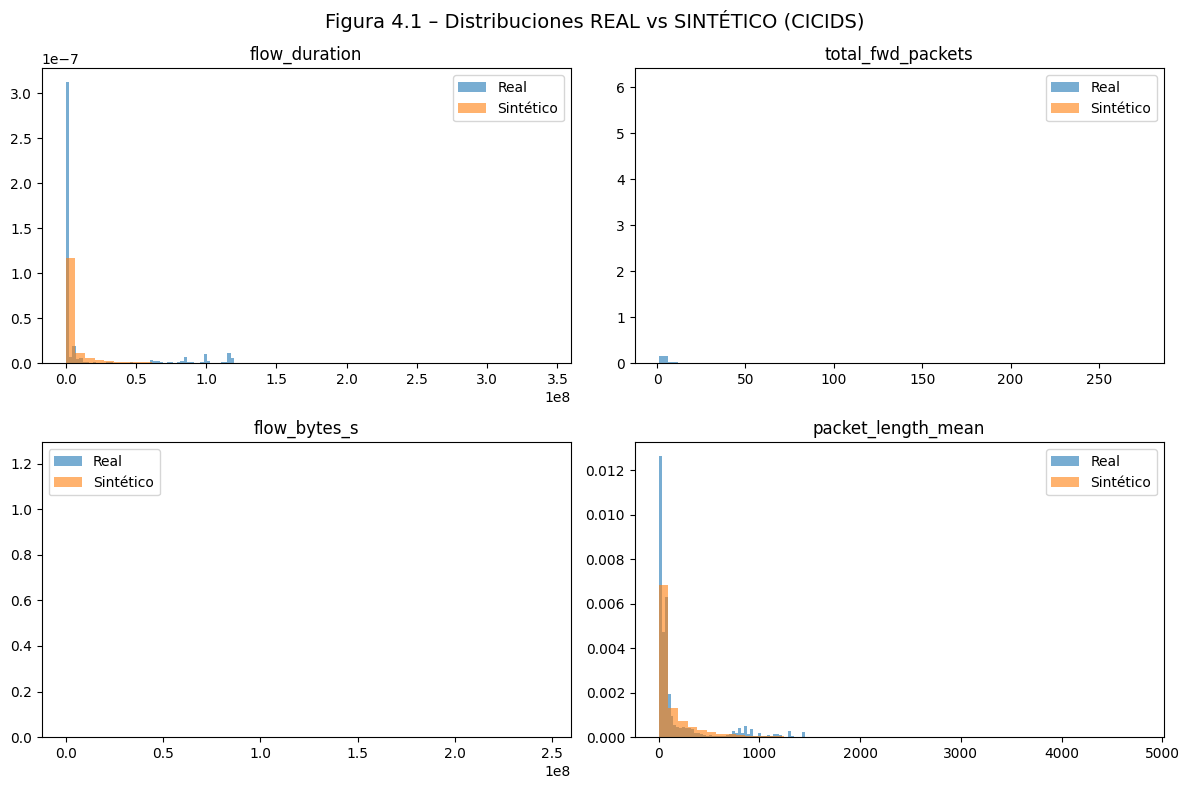

In [ ]:
# ===================== FIGURA 4.1 =====================
# Distribución REAL vs SINTÉTICO (CICIDS)
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

REAL_CSV = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"
SYN_CSV  = "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv"

# Variables numéricas representativas
NUM_COLS = [
    "flow_duration",
    "total_fwd_packets",
    "flow_bytes_s",
    "packet_length_mean"
]

N_SAMPLE = 50_000  # submuestra segura

def load_sample(path, n):
    df = pd.read_csv(path, usecols=NUM_COLS)
    if len(df) > n:
        df = df.sample(n=n, random_state=42)
    return df

df_real = load_sample(REAL_CSV, N_SAMPLE)
df_syn  = load_sample(SYN_CSV, N_SAMPLE)

plt.figure(figsize=(12, 8))

for i, col in enumerate(NUM_COLS, 1):
    plt.subplot(2, 2, i)
    plt.hist(df_real[col], bins=50, density=True, alpha=0.6, label="Real")
    plt.hist(df_syn[col],  bins=50, density=True, alpha=0.6, label="Sintético")
    plt.title(col)
    plt.legend()

plt.suptitle("Figura 4.1 – Distribuciones REAL vs SINTÉTICO (CICIDS)", fontsize=14)
plt.tight_layout()
plt.savefig("/gdrive/MyDrive/MasterIA/Imagenes/figura_4_1_distribuciones_real_vs_sintetico.png", dpi=300)
plt.show()


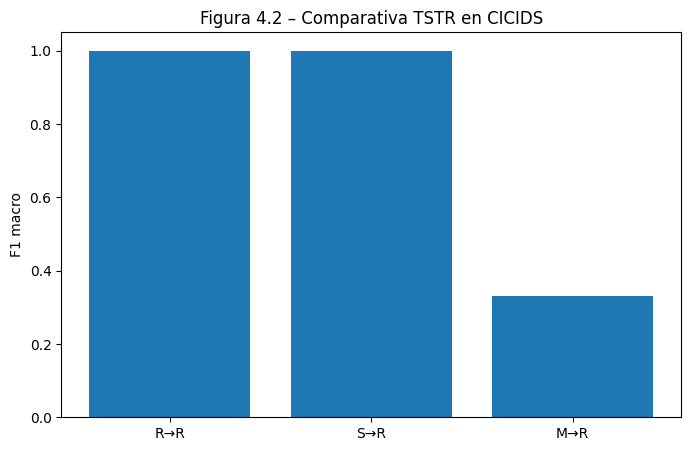

In [ ]:
# ===================== FIGURA 4.2 =====================
# Comparativa TSTR (CICIDS)
# ======================================

import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Escenario": ["R→R", "S→R", "M→R"],
    "Accuracy": [1.00, 1.00, 0.50],
    "F1_macro": [1.00, 1.00, 0.33]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
plt.bar(df["Escenario"], df["F1_macro"])
plt.ylim(0, 1.05)
plt.ylabel("F1 macro")
plt.title("Figura 4.2 – Comparativa TSTR en CICIDS")

plt.savefig("/gdrive/MyDrive/MasterIA/Imagenes/figura_4_2_tstr_comparativa.png", dpi=300)
plt.show()


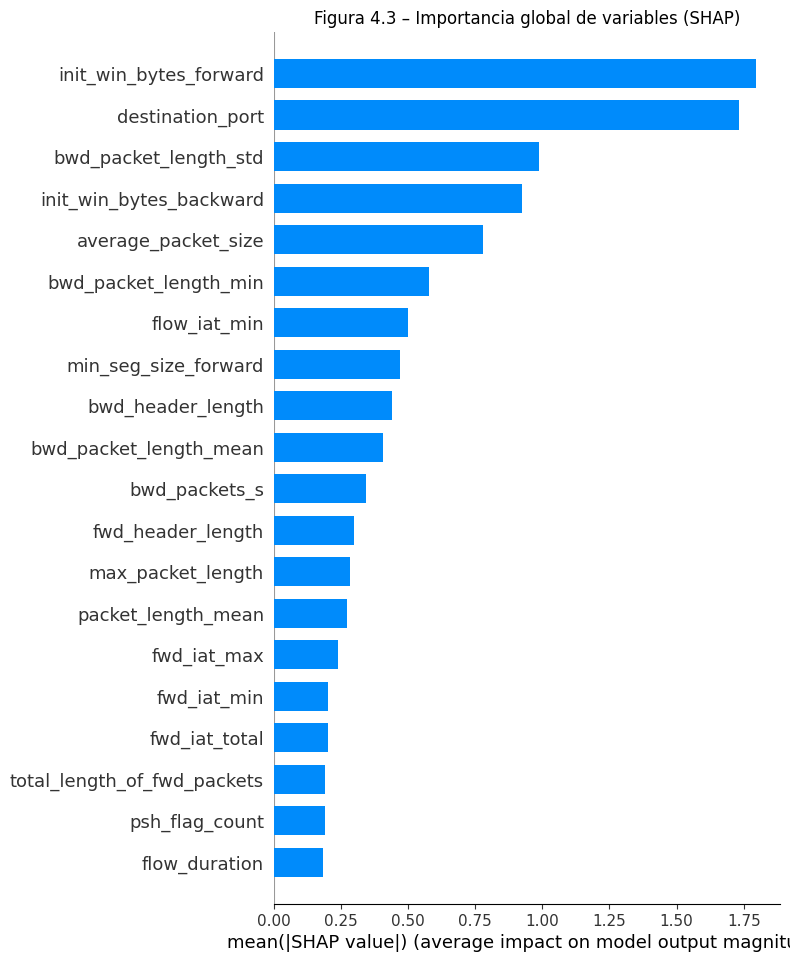

In [ ]:
# ===================== FIGURA 4.3 =====================
# SHAP Global (CICIDS)
# ======================================

import shap
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

REAL_CSV = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"

N_SAMPLE = 100_000
SHAP_N   = 2000

df = pd.read_csv(REAL_CSV)
df = df.sample(n=N_SAMPLE, random_state=42)

y = df["label"].astype(int)
X = df.drop(columns=["label", "attack_cat"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss",
    n_jobs=-1
)

model.fit(X_train, y_train)

X_shap = X_test.sample(n=SHAP_N, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False
)

plt.title("Figura 4.3 – Importancia global de variables (SHAP)")
plt.savefig("/gdrive/MyDrive/MasterIA/Imagenes/figura_4_3_shap_global.png", dpi=300, bbox_inches="tight")
plt.show()


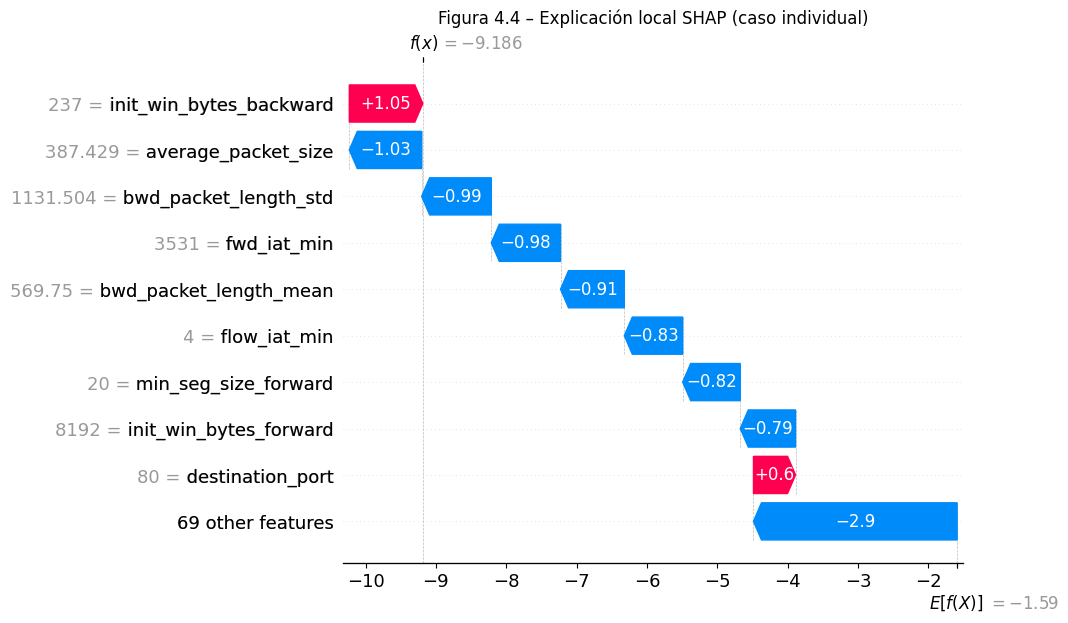

In [ ]:
# ===================== FIGURA 4.4 =====================
# SHAP Local (caso pericial)
# ======================================

idx = 0  # primer caso de la submuestra SHAP

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_shap.iloc[idx],
        feature_names=X_shap.columns
    ),
    show=False
)

plt.title("Figura 4.4 – Explicación local SHAP (caso individual)")
plt.savefig("/gdrive/MyDrive/MasterIA/Imagenes/figura_4_4_shap_local.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# ===================== ANEXO I + ANEXO II (CICIDS MachineLearningCVE) =====================
# - Figuras A.1..A.4 (Anexo Técnico I)
# - Figuras B.* por ataque (Brute Force, PortScan, DoS) (Anexo Técnico II)
#
# Requisitos (Drive montado si usas rutas gdrive):
#   REAL: /gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv
#   SYN : /gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv
#
# Salidas:
#   //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/
#
# Nota: detección binaria (label) como hilo principal. SHAP para XAI.

!pip install -q tqdm shap xgboost scipy matplotlib

import os, gc, time, re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import shap
import xgboost as xgb

# ===================== CONFIG =====================
REAL_CSV = "/gdrive/MyDrive/Datasets/MachineLearningCVE_full_clean.csv"
SYN_CSV  = "/gdrive/MyDrive/Datasets/synthetic_MachineLearningCVE_ctgan.csv"
OUT_DIR  = "//gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras"

RANDOM_STATE = 42

# Muestreo (ajusta si tu Colab tiene menos RAM)
REAL_SAMPLE_N = 250_000     # total real para trabajar
SYN_SAMPLE_N  = 250_000     # total sintético para trabajar
CHUNK_REAL    = 200_000
CHUNK_SYN     = 200_000

TEST_SIZE = 0.20

# XGBoost
XGB_PARAMS = dict(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss"
)

# Figuras: A.1 variables a graficar (si no existen, se ignoran)
DIST_VARS = [
    "flow_bytes_s", "total_fwd_packets", "total_backward_packets",
    "flow_duration", "flow_packets_s", "fwd_packets_s"
]

# KS-test sobre estas variables (si no existen, se ignoran)
KS_VARS = [
    "flow_bytes_s", "total_fwd_packets", "total_backward_packets",
    "flow_duration", "flow_packets_s", "fwd_iat_mean", "bwd_iat_mean"
]

# SHAP
SHAP_GLOBAL_N = 2000
SHAP_LOCAL_BACKGROUND_N = 500
TOPN_SHAP_GLOBAL = 20

# Anexo II ataques a analizar (match flexible)
ATTACKS = [
    ("Brute Force", ["brute", "ftp", "ssh"]),   # lo hacemos robusto
    ("PortScan",    ["portscan", "port scan"]),
    ("DoS",         ["dos", "ddos", "hulk", "slowloris", "slowhttptest", "goldeneye"])
]

os.makedirs(OUT_DIR, exist_ok=True)

# ===================== UTILIDADES =====================
def normalize_cols(cols):
    return [str(c).strip().replace(" ", "_").replace("/", "_").replace("-", "_").lower() for c in cols]

def ensure_cols(df):
    df.columns = normalize_cols(df.columns)
    # attack_cat puede no estar; si está la limpiamos
    if "attack_cat" in df.columns:
        df["attack_cat"] = df["attack_cat"].astype(str).str.strip()
        df["attack_cat"] = df["attack_cat"].replace({"nan":"Normal","NaN":"Normal","None":"Normal","":"Normal"}).fillna("Normal")
    # label binario
    if "label" in df.columns:
        df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int).clip(0,1)
    return df

def stratified_sample_csv(path, n_rows, chunksize, label_col="label", seed=42):
    """
    Muestreo estratificado por label leyendo por chunks, para controlar memoria.
    Intenta devolver ~n_rows (mitad label=0, mitad label=1 si hay).
    """
    rng = np.random.RandomState(seed)
    target_total = n_rows
    target_0 = target_total // 2
    target_1 = target_total - target_0
    got_0 = 0
    got_1 = 0
    parts = []

    reader = pd.read_csv(path, low_memory=False, chunksize=chunksize)
    for ch in tqdm(reader, desc=f"Sampling {os.path.basename(path)}", unit="chunk"):
        ch = ensure_cols(ch)
        if label_col not in ch.columns:
            raise ValueError(f"Falta {label_col} en {path}")

        if got_0 < target_0:
            sub0 = ch[ch[label_col] == 0]
            if len(sub0) > 0:
                need = target_0 - got_0
                take = min(need, len(sub0))
                parts.append(sub0.sample(n=take, random_state=int(rng.randint(0, 1e9))))
                got_0 += take

        if got_1 < target_1:
            sub1 = ch[ch[label_col] == 1]
            if len(sub1) > 0:
                need = target_1 - got_1
                take = min(need, len(sub1))
                parts.append(sub1.sample(n=take, random_state=int(rng.randint(0, 1e9))))
                got_1 += take

        del ch
        gc.collect()

        if (got_0 + got_1) >= target_total:
            break

    if not parts:
        raise RuntimeError("No se pudo muestrear nada.")
    df = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    if len(df) > target_total:
        df = df.sample(n=target_total, random_state=seed).reset_index(drop=True)
    return df

def build_preprocessor(X_real, X_syn):
    common = [c for c in X_real.columns if c in X_syn.columns]
    Xr = X_real[common].copy()
    Xs = X_syn[common].copy()

    num_cols = [c for c in common if pd.api.types.is_numeric_dtype(Xr[c]) and pd.api.types.is_numeric_dtype(Xs[c])]
    cat_cols = [c for c in common if c not in num_cols]

    for c in num_cols:
        Xr[c] = Xr[c].replace([np.inf, -np.inf], np.nan).fillna(0)
        Xs[c] = Xs[c].replace([np.inf, -np.inf], np.nan).fillna(0)
    for c in cat_cols:
        Xr[c] = Xr[c].astype(str).fillna("__NA__")
        Xs[c] = Xs[c].astype(str).fillna("__NA__")

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    pre = ColumnTransformer(
        transformers=[
            ("cat", ohe, cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    pre.fit(pd.concat([Xr, Xs], axis=0, ignore_index=True))
    return pre, common, cat_cols, num_cols

def eval_binary(model, X_test_enc, y_test, name=""):
    y_pred = model.predict(X_test_enc).astype(int)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"\n==================== {name} ====================")
    print(f"Accuracy: {acc:.4f} | F1(w): {f1w:.4f} | F1(macro): {f1m:.4f}")
    print("\n[Classification report]")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print("\n[Confusion matrix] (filas=real, cols=pred)")
    print(confusion_matrix(y_test, y_pred))
    return {"acc": acc, "f1w": f1w, "f1macro": f1m}

def row_to_dense_1d(row):
    """Convierte fila sparse o dense en vector 1D numpy."""
    if hasattr(row, "toarray"):
        return row.toarray().ravel()
    return np.asarray(row).ravel()

def safe_get_feature_names(pre, cat_cols, num_cols):
    feat_names = []
    ohe = pre.named_transformers_.get("cat", None)
    if ohe is not None and len(cat_cols) > 0:
        feat_names += ohe.get_feature_names_out(cat_cols).tolist()
    feat_names += num_cols
    return feat_names

def pick_attack_rows(df, keywords):
    """
    Devuelve subset por attack_cat que contenga alguno de los keywords.
    Si no hay attack_cat, devuelve vacío.
    """
    if "attack_cat" not in df.columns:
        return df.iloc[0:0].copy()

    patt = "(" + "|".join([re.escape(k.lower()) for k in keywords]) + ")"
    mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)
    return df[mask].copy()

# ===================== FIGURAS ANEXO I =====================
def figure_A1_distributions(out_path, df_real, df_syn, vars_list):
    # Solo variables existentes y numéricas
    cols = []
    for v in vars_list:
        v = v.lower()
        if v in df_real.columns and v in df_syn.columns:
            if pd.api.types.is_numeric_dtype(df_real[v]) and pd.api.types.is_numeric_dtype(df_syn[v]):
                cols.append(v)
    cols = cols[:6]  # máximo 6 para que sea legible
    if not cols:
        print("[WARN] Figura A.1: no hay variables válidas para graficar.")
        return

    n = len(cols)
    fig, axes = plt.subplots(n, 2, figsize=(12, 3*n), constrained_layout=True)
    if n == 1:
        axes = np.array([axes])

    for i, c in enumerate(cols):
        r = df_real[c].replace([np.inf, -np.inf], np.nan).dropna()
        s = df_syn[c].replace([np.inf, -np.inf], np.nan).dropna()
        # recortar percentiles para visibilidad (sin log)
        rp = np.clip(r, np.percentile(r, 1), np.percentile(r, 99))
        sp = np.clip(s, np.percentile(s, 1), np.percentile(s, 99))

        axes[i, 0].hist(rp, bins=60)
        axes[i, 0].set_title(f"REAL: {c}")
        axes[i, 1].hist(sp, bins=60)
        axes[i, 1].set_title(f"SINTÉTICO: {c}")

    fig.suptitle("Figura A.1 — Distribuciones REAL vs SINTÉTICO (CICIDS MachineLearningCVE)", fontsize=14)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura A.1 ->", out_path)

def figure_A2_ks(out_path, df_real, df_syn, vars_list):
    rows = []
    for v in vars_list:
        v = v.lower()
        if v in df_real.columns and v in df_syn.columns:
            if pd.api.types.is_numeric_dtype(df_real[v]) and pd.api.types.is_numeric_dtype(df_syn[v]):
                r = df_real[v].replace([np.inf, -np.inf], np.nan).dropna()
                s = df_syn[v].replace([np.inf, -np.inf], np.nan).dropna()
                if len(r) > 0 and len(s) > 0:
                    # submuestreo para rapidez
                    rr = r.sample(n=min(20000, len(r)), random_state=RANDOM_STATE)
                    ss = s.sample(n=min(20000, len(s)), random_state=RANDOM_STATE)
                    ks = ks_2samp(rr, ss).statistic
                    rows.append((v, float(ks)))

    if not rows:
        print("[WARN] Figura A.2: no hay variables válidas para KS.")
        return

    ks_df = pd.DataFrame(rows, columns=["variable", "ks_stat"]).sort_values("ks_stat", ascending=False)
    ks_df.to_csv(os.path.join(OUT_DIR, "Tabla_A2_KS_por_variable.csv"), index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(ks_df["variable"].head(15)[::-1], ks_df["ks_stat"].head(15)[::-1])
    plt.title("Figura A.2 — KS-test (|D|) por variable (top 15)")
    plt.xlabel("KS statistic")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura A.2 ->", out_path)
    print("[OK] Tabla A.2 (CSV) ->", os.path.join(OUT_DIR, "Tabla_A2_KS_por_variable.csv"))

def figure_A3_shap_global(out_path, model, pre, common_cols, feat_names, X_test_df, n=2000):
    X_enc = pre.transform(X_test_df[common_cols])
    take = min(n, X_enc.shape[0])
    idx = np.random.RandomState(RANDOM_STATE).choice(X_enc.shape[0], size=take, replace=False)
    X_shap = X_enc[idx]

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_shap)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    # resumen (bar) sin mostrar en notebook
    plt.figure()
    shap.summary_plot(shap_vals, features=X_shap, feature_names=feat_names,
                      plot_type="bar", max_display=TOPN_SHAP_GLOBAL, show=False)
    plt.title("Figura A.3 — SHAP global (importancia de variables)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura A.3 ->", out_path)

def figure_A4_shap_local(out_path, model, pre, common_cols, feat_names, X_test_df, y_test, pick_label=1):
    X_enc = pre.transform(X_test_df[common_cols])
    pred = model.predict(X_enc).astype(int)
    y = np.asarray(y_test).astype(int)

    if pick_label == 1:
        mask = (y == 1) & (pred == 1)
        title = "Figura A.4 — SHAP local (caso REAL: ataque bien detectado)"
    else:
        mask = (y == 0) & (pred == 0)
        title = "Figura A.4 — SHAP local (caso REAL: normal bien detectado)"

    idxs = np.where(mask)[0]
    idx0 = int(idxs[0]) if len(idxs) else 0

    bg_n = min(SHAP_LOCAL_BACKGROUND_N, X_enc.shape[0])
    bg_idx = np.random.RandomState(RANDOM_STATE).choice(X_enc.shape[0], size=bg_n, replace=False)
    background = X_enc[bg_idx]

    explainer = shap.TreeExplainer(model, data=background)
    shap_vals = explainer.shap_values(X_enc[idx0])
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    exp = shap.Explanation(
        values=np.asarray(shap_vals).ravel(),
        base_values=explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0],
        data=row_to_dense_1d(X_enc[idx0]),
        feature_names=feat_names
    )

    plt.figure()
    shap.plots.waterfall(exp, show=False, max_display=15)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura A.4 ->", out_path)

# ===================== ANEXO II (por ataque) =====================
def figure_attack_distributions(out_path, df_real_attack, df_syn_attack, vars_list, attack_name):
    cols = []
    for v in vars_list:
        v = v.lower()
        if v in df_real_attack.columns and v in df_syn_attack.columns:
            if pd.api.types.is_numeric_dtype(df_real_attack[v]) and pd.api.types.is_numeric_dtype(df_syn_attack[v]):
                cols.append(v)
    cols = cols[:4]
    if not cols:
        print(f"[WARN] {attack_name}: no hay variables válidas para distribuciones.")
        return

    n = len(cols)
    fig, axes = plt.subplots(n, 2, figsize=(12, 3*n), constrained_layout=True)
    if n == 1:
        axes = np.array([axes])

    for i, c in enumerate(cols):
        r = df_real_attack[c].replace([np.inf, -np.inf], np.nan).dropna()
        s = df_syn_attack[c].replace([np.inf, -np.inf], np.nan).dropna()
        if len(r) == 0 or len(s) == 0:
            continue
        rp = np.clip(r, np.percentile(r, 1), np.percentile(r, 99))
        sp = np.clip(s, np.percentile(s, 1), np.percentile(s, 99))
        axes[i, 0].hist(rp, bins=60)
        axes[i, 0].set_title(f"REAL ({attack_name}): {c}")
        axes[i, 1].hist(sp, bins=60)
        axes[i, 1].set_title(f"SINTÉTICO ({attack_name}): {c}")

    fig.suptitle(f"Distribuciones REAL vs SINTÉTICO — {attack_name}", fontsize=14)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura ataque distribuciones ->", out_path)

def figure_attack_shap_local(out_path, model, pre, common_cols, feat_names, df_source, title=""):
    if len(df_source) == 0:
        print("[WARN] SHAP local: df_source vacío para", title)
        return

    # Submuestreo rápido
    df_source = df_source.sample(n=min(5000, len(df_source)), random_state=RANDOM_STATE)
    X = df_source.drop(columns=["label"], errors="ignore")
    y = df_source["label"].astype(int).values if "label" in df_source.columns else None

    X_enc = pre.transform(X[common_cols])
    pred = model.predict(X_enc).astype(int)

    # Intento elegir un ataque bien clasificado (label=1)
    idx0 = 0
    if y is not None:
        mask = (y == 1) & (pred == 1)
        idxs = np.where(mask)[0]
        if len(idxs):
            idx0 = int(idxs[0])

    bg_n = min(SHAP_LOCAL_BACKGROUND_N, X_enc.shape[0])
    bg_idx = np.random.RandomState(RANDOM_STATE).choice(X_enc.shape[0], size=bg_n, replace=False)
    background = X_enc[bg_idx]

    explainer = shap.TreeExplainer(model, data=background)
    shap_vals = explainer.shap_values(X_enc[idx0])
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    exp = shap.Explanation(
        values=np.asarray(shap_vals).ravel(),
        base_values=explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0],
        data=row_to_dense_1d(X_enc[idx0]),
        feature_names=feat_names
    )

    plt.figure()
    shap.plots.waterfall(exp, show=False, max_display=15)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("[OK] Figura SHAP local ataque ->", out_path)

# ===================== MAIN =====================
print("[1/5] Cargando muestras...")
df_real = stratified_sample_csv(REAL_CSV, REAL_SAMPLE_N, CHUNK_REAL, label_col="label", seed=RANDOM_STATE)
df_syn  = stratified_sample_csv(SYN_CSV,  SYN_SAMPLE_N,  CHUNK_SYN,  label_col="label", seed=RANDOM_STATE)

df_real = ensure_cols(df_real)
df_syn  = ensure_cols(df_syn)

print("[OK] df_real:", df_real.shape, "| label:", df_real["label"].value_counts().to_dict())
print("[OK] df_syn :", df_syn.shape,  "| label:", df_syn["label"].value_counts().to_dict())

# Split REAL train/test
X_real = df_real.drop(columns=["label"], errors="ignore")
y_real = df_real["label"].astype(int).values

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_real, y_real, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_real
)

# SYN
X_syn = df_syn.drop(columns=["label"], errors="ignore")
y_syn = df_syn["label"].astype(int).values

print("[OK] Real train/test:", Xr_train.shape, Xr_test.shape, "| Syn:", X_syn.shape)

print("[2/5] Preprocesado + entrenamiento XGBoost...")
pre, common_cols, cat_cols, num_cols = build_preprocessor(Xr_train, X_syn)
feat_names = safe_get_feature_names(pre, cat_cols, num_cols)

X_train_enc = pre.transform(Xr_train[common_cols])
X_test_enc  = pre.transform(Xr_test[common_cols])

model = xgb.XGBClassifier(**XGB_PARAMS)
t0 = time.time()
model.fit(X_train_enc, yr_train)
print("[OK] Train seconds:", round(time.time()-t0, 2))

metrics = eval_binary(model, X_test_enc, yr_test, name="XGB (REAL train → REAL test)")

# Guardar tabla de métricas
pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR, "Tabla_A0_metricas_modelo.csv"), index=False)

print("[3/5] Generando Figuras Anexo I (A.1..A.4)...")
figure_A1_distributions(os.path.join(OUT_DIR, "Figura_A1_Distribuciones_REAL_vs_SYN.png"),
                        df_real, df_syn, DIST_VARS)

figure_A2_ks(os.path.join(OUT_DIR, "Figura_A2_KS_por_variable.png"),
             df_real, df_syn, KS_VARS)

figure_A3_shap_global(os.path.join(OUT_DIR, "Figura_A3_SHAP_global.png"),
                      model, pre, common_cols, feat_names, Xr_test, n=SHAP_GLOBAL_N)

figure_A4_shap_local(os.path.join(OUT_DIR, "Figura_A4_SHAP_local.png"),
                     model, pre, common_cols, feat_names, Xr_test, yr_test, pick_label=1)

print("[4/5] Generando Anexo II (por ataque)...")
for attack_name, keywords in ATTACKS:
    df_real_attack = pick_attack_rows(df_real, keywords)
    df_syn_attack  = pick_attack_rows(df_syn, keywords)

    # si no encuentra nada, lo avisamos pero seguimos
    print(f"\n[INFO] {attack_name}: real={len(df_real_attack)} | syn={len(df_syn_attack)}")

    # Figura B.x distribuciones
    figure_attack_distributions(
        os.path.join(OUT_DIR, f"Figura_B_{attack_name}_Distribuciones_REAL_vs_SYN.png"),
        df_real_attack, df_syn_attack, DIST_VARS, attack_name
    )

    # SHAP local en real (si hay)
    if len(df_real_attack) > 0:
        figure_attack_shap_local(
            os.path.join(OUT_DIR, f"Figura_B_{attack_name}_SHAP_local_REAL.png"),
            model, pre, common_cols, feat_names, df_real_attack,
            title=f"{attack_name} — SHAP local (caso REAL, interpretabilidad pericial)"
        )

    # SHAP local en sintético (si hay)
    if len(df_syn_attack) > 0:
        figure_attack_shap_local(
            os.path.join(OUT_DIR, f"Figura_B_{attack_name}_SHAP_local_SYN.png"),
            model, pre, common_cols, feat_names, df_syn_attack,
            title=f"{attack_name} — SHAP local (caso SINTÉTICO, interpretabilidad pericial)"
        )

print("[5/5] FIN ✅")
print("Revisa la carpeta:", OUT_DIR)


[1/5] Cargando muestras...


Sampling MachineLearningCVE_full_clean.csv: 0chunk [00:00, ?chunk/s]

Sampling synthetic_MachineLearningCVE_ctgan.csv: 0chunk [00:00, ?chunk/s]

[OK] df_real: (250000, 80) | label: {0: 125000, 1: 125000}
[OK] df_syn : (215000, 80) | label: {0: 125000, 1: 90000}
[OK] Real train/test: (200000, 79) (50000, 79) | Syn: (215000, 79)
[2/5] Preprocesado + entrenamiento XGBoost...
[OK] Train seconds: 13.52

==================== XGB (REAL train → REAL test) ====================
Accuracy: 1.0000 | F1(w): 1.0000 | F1(macro): 1.0000

[Classification report]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     25000
           1     1.0000    1.0000    1.0000     25000

    accuracy                         1.0000     50000
   macro avg     1.0000    1.0000    1.0000     50000
weighted avg     1.0000    1.0000    1.0000     50000


[Confusion matrix] (filas=real, cols=pred)
[[25000     0]
 [    0 25000]]
[3/5] Generando Figuras Anexo I (A.1..A.4)...
[OK] Figura A.1 -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_A1_Distribuciones_REAL_vs_SYN.png
[OK] Figura A.2 -> //gdr

/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)
/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)



[INFO] Brute Force: real=0 | syn=0
[OK] Figura ataque distribuciones -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_Brute Force_Distribuciones_REAL_vs_SYN.png


/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)
/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)



[INFO] PortScan: real=0 | syn=30000
[OK] Figura ataque distribuciones -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_PortScan_Distribuciones_REAL_vs_SYN.png
[OK] Figura SHAP local ataque -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_PortScan_SHAP_local_SYN.png


/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)
/tmp/ipython-input-3043474336.py:212: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["attack_cat"].astype(str).str.lower().str.contains(patt, regex=True, na=False)



[INFO] DoS: real=125000 | syn=30000
[OK] Figura ataque distribuciones -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_DoS_Distribuciones_REAL_vs_SYN.png
[OK] Figura SHAP local ataque -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_DoS_SHAP_local_REAL.png
[OK] Figura SHAP local ataque -> //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras/Figura_B_DoS_SHAP_local_SYN.png
[5/5] FIN ✅
Revisa la carpeta: //gdrive/MyDrive/MasterIA/Imagenes/Anexos/TFM_outputs_figuras
